# Mercado Inmobiliario - Proyecto 2

## Consigna

En este proyecto profundizarás lo desarrollado en el proyecto 01 (“Primer modelo de Machine Learning”). El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

El trabajo se organiza en tres partes:

### Parte A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:

*Detección y eliminación de Outliers:* El dataset cuenta con outliers dado al EDA del proyecto 1, se implementaran varias tecnicas de deteccion y se elegira el mejor.

*Encoding*: Se crearán variables dummy para Zonas y Tipos de propiedad, ya que éstas son categóricas nominales.

*Imputación de valores faltantes*: Se analizarán los valores faltantes de Baños, Superficie Total y Cubierta, y se imputarán.

*Escalado de datos*: En algunos análisis será necesario realizar esta técnica, entre ellas, análisis de cluster y detección de Outliers.

Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA): Se entrenarán los modelos con variables reducidas.

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

#### Importando librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, IterativeImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest, BaggingRegressor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import KFold
sns.set()

#### Lectura del dataset

In [2]:
original_data = pd.read_csv('../DS_Proyecto_01_Datos_Properati.csv')

In [3]:
data = original_data.copy()
data.head(3)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta


In [4]:
data.drop(columns=['lat', 'lon', 'l1', 'l3', 'end_date','start_date', 'created_on', 'currency', 'title',
                   'description', 'operation_type'], inplace=True)
data.head()

,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,2.0,1.0,1.0,50.0,35.0,40000.0,PH


#### Filtros

Filtrando columna *property_type* para los tipos de propiedad con una cantidad superior a 1000.

In [5]:
data['property_type'].value_counts()

Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64

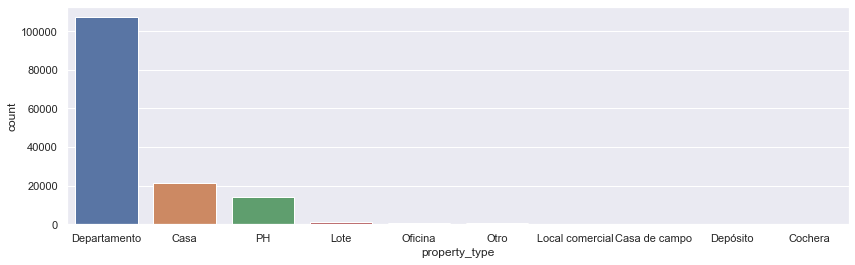

In [6]:
plt.figure(figsize=(14,4))
sns.countplot(data['property_type'], order=data['property_type'].value_counts().index)

In [7]:
counts = data['property_type'].value_counts().head(3)
properties = data['property_type'].isin(counts.index)
data = data[properties]
print('Shape:', data.shape)

Shape: (143145, 8)


#### Exploración de Valores Faltantes

In [8]:
data.isna().sum()

l2                     0
rooms                  0
bedrooms               0
bathrooms           4211
surface_total      18623
surface_covered    18909
price                  0
property_type          0
dtype: int64

In [9]:
def heatmap_nan_values(data, title='Valores Faltantes por columna'):
    # Plot Valores faltantes por columna
    plt.title(title, fontsize=18, pad=40)
    ax = sns.heatmap(data.isna(), cbar=False, fmt='d')
    width = ax.get_xlim()[1]/data.columns.size
    nan_values = data.isna().sum()
    for i, _ in enumerate(data.columns):
        ax.axvline(width+i, c='white')

Antes:


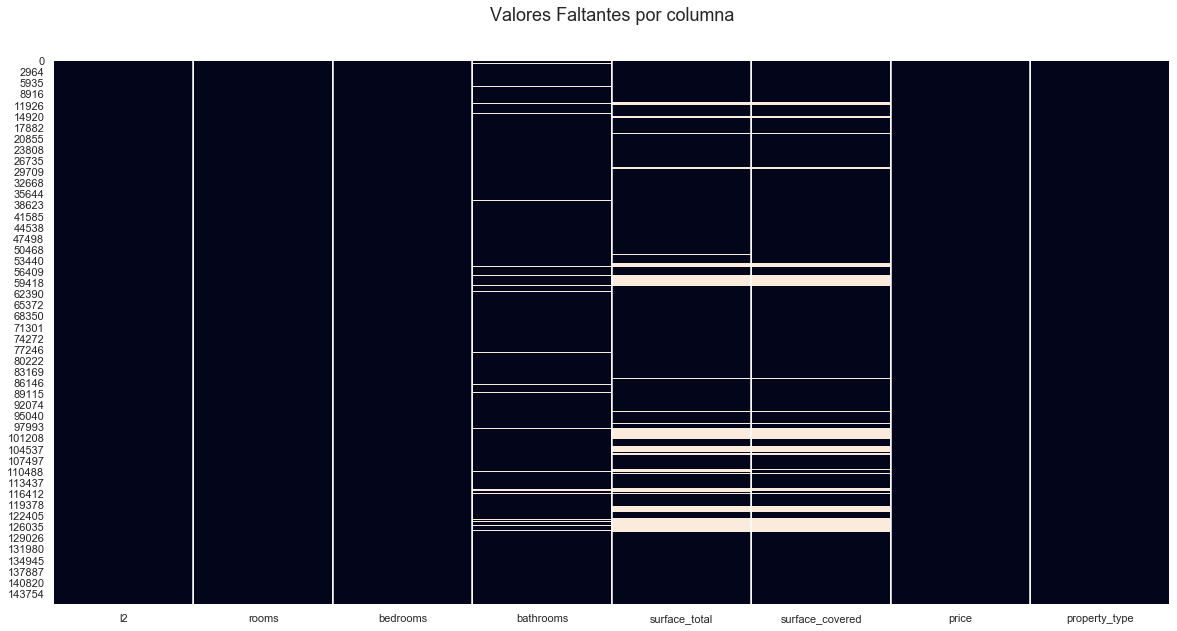

In [10]:
print('Antes:')
plt.figure(figsize=(20,10))  
heatmap_nan_values(data)

##### Bathrooms

Valores faltantes por intervalos:

In [11]:
def plot_bin_freq_nan(data, col_inter, col_target, bins=30):
    data2 = data.copy()
    col_inter = col_inter

    data2['intervals'] = pd.cut(data[col_inter], bins=bins)
    inter = data2[col_target].isna().groupby(
        data2.intervals).sum().astype(int).reset_index(name='count')
    inter['freq'] = inter['count'] / \
        data2[col_target].groupby([data2.intervals]).count().values
    inter['mid'] = inter.intervals.apply(lambda x: x.mid)
    # Plot
    plt.title(f'{col_target} / {col_inter}', fontdict={'fontsize': 14})
    plt.scatter(inter.mid, inter.freq)
    plt.xlabel('Intervalos: '+col_inter)
    plt.ylabel('Frecuencias NaN')

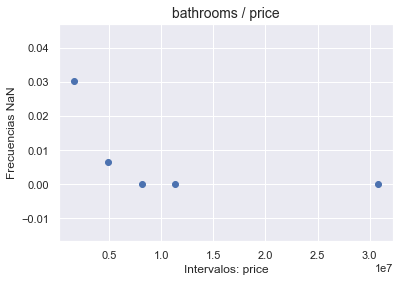

In [12]:
plot_bin_freq_nan(data, 'price','bathrooms',10)

La variable baños es __MNAR__ con respecto al precio. Se aprecia una relacion decreciente y proporcional.

Como se trata de una variable continua discreta y tipo entero, se rellenarán sus valores faltantes de acuerdo a la moda de ésta variable, teniendo en cuenta las zonas y el tipo de propiedad:

* Agregando indicador de dato faltante usando sklearn:

In [13]:
indicator_bathrooms = MissingIndicator().fit_transform(data[['bathrooms']])
data['missing_bathrooms'] = indicator_bathrooms.astype(int)
data.head()

,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,missing_bathrooms
0,Capital Federal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,0
1,Capital Federal,2.0,1.0,2.0,70.0,58.0,159000.0,PH,0
2,Capital Federal,2.0,1.0,1.0,45.0,45.0,125000.0,PH,0
3,Capital Federal,2.0,1.0,1.0,85.0,50.0,295000.0,PH,0
4,Bs.As. G.B.A. Zona Sur,2.0,1.0,1.0,50.0,35.0,40000.0,PH,0


* Distribución porcentual de Valores faltantes por zona y tipo de propiedad:

In [14]:
def barplot_missing_values(data, col):
    # Dataframe nuevo con valores faltantes
    data_na = (data.isna()[col].groupby(
        [data.l2, data.property_type]).sum()/data[col].groupby(
        [data.l2, data.property_type]).count()).to_frame().reset_index()
    data_na.sort_values(by=[col], ascending=False, inplace=True)

    # Grafica
    plt.title(f'Valores Faltantes: {col}', fontdict={'fontsize': 15}, pad=20)
    sns.barplot(data=data_na, x='property_type', y=col, hue='l2', palette='PuBu_r')
    plt.ylabel('Valores faltantes', fontdict={'fontsize': 13}, labelpad=20)
    plt.xlabel('Tipo de propiedad', fontdict={'fontsize': 13}, labelpad=20)

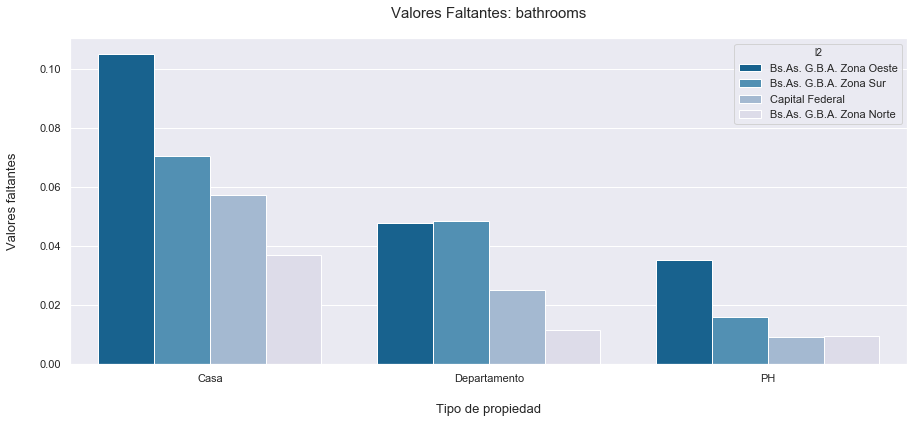

In [15]:
plt.figure(figsize=(15, 6))
barplot_missing_values(data, 'bathrooms')

* Valor más frecuente sin valores faltantes con segmentación por zona y tipo de propiedad:

In [16]:
def get_pivot_table():
    return data.pivot_table(index='l2', columns='property_type', aggfunc=lambda x: x.groupby(
        by=[data['property_type'], data['l2']]).agg(lambda y: y.value_counts().index[0]))['bathrooms']

In [17]:
get_pivot_table()

property_type,Casa,Departamento,PH
l2,,,
Bs.As. G.B.A. Zona Norte,2.0,1.0,1.0
Bs.As. G.B.A. Zona Oeste,1.0,1.0,1.0
Bs.As. G.B.A. Zona Sur,2.0,1.0,1.0
Capital Federal,2.0,1.0,1.0


* Aplicando el método para llenar valores faltantes:  
Se llenaran los valores faltantes con la Moda especializando por tipo de propiedad y zona, y no de toda la columna.

In [18]:
data['bathrooms'].fillna(data['bathrooms'].groupby(
    [data.property_type, data.l2]).transform(lambda x: x.value_counts().index[0]), inplace=True)

In [19]:
get_pivot_table()

property_type,Casa,Departamento,PH
l2,,,
Bs.As. G.B.A. Zona Norte,2.0,1.0,1.0
Bs.As. G.B.A. Zona Oeste,1.0,1.0,1.0
Bs.As. G.B.A. Zona Sur,2.0,1.0,1.0
Capital Federal,2.0,1.0,1.0


In [20]:
print('Despues:')
plt.figure(figsize=(20,10))
#heatmap_nan_values(data)

Despues:


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

##### SurfaceTotal

* Valores faltantes por intervalos:

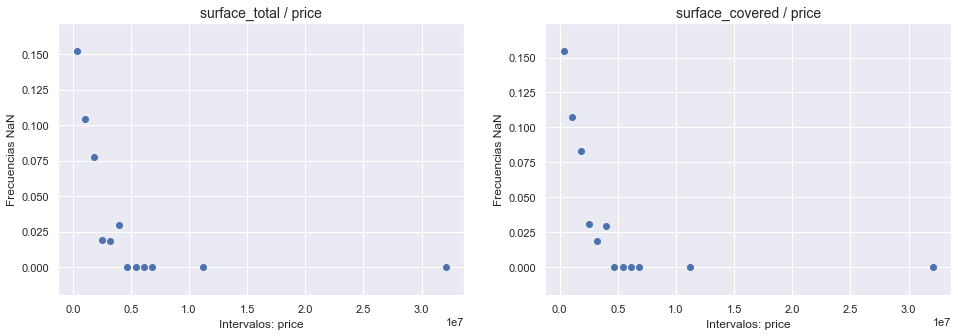

In [21]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_bin_freq_nan(data, 'price', 'surface_total', 45)
plt.subplot(1, 2, 2)
plot_bin_freq_nan(data, 'price', 'surface_covered', 45)

La variable Superficie Total y Cubierta tambien son MNAR con respecto al precio. Se aprecia una relacion decreciente y proporcional.

* Heatmap de valores faltantes

In [22]:
plt.figure(figsize=(20, 10))

def heatmaps_by_column(data, col):
    categories = set(data[col])
    for i, category in enumerate(categories, start=1):
        df = data.query(f'{col}==@category')
        plt.subplot(1, len(categories), i)
        plt.title(category)
        heatmap_nan_values(df[['surface_covered', 'surface_total']], category)

<Figure size 1440x720 with 0 Axes>

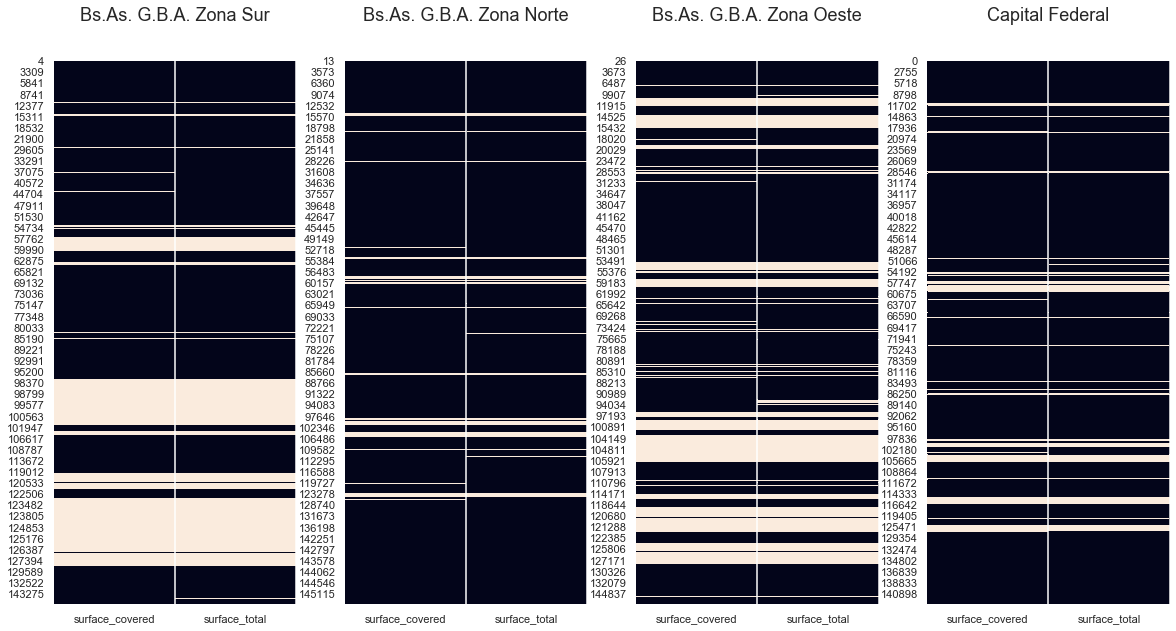

In [23]:
plt.figure(figsize=(20,10))
heatmaps_by_column(data, 'l2')

En Zona Sur se nota una gran franja de valores faltante, quizás se debe a zonas marginadas de las cuales no se tiene mucho registro.

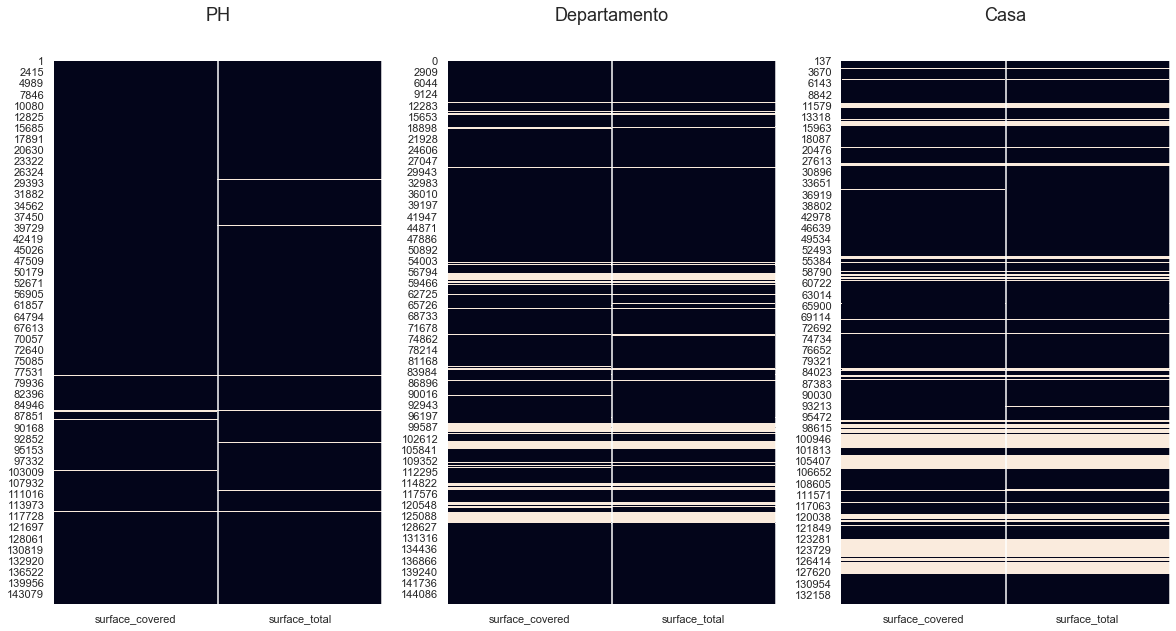

In [24]:
plt.figure(figsize=(20,10))
heatmaps_by_column(data, 'property_type')

* Distribución porcentual de Valores faltantes por zona y tipo de propiedad para Superficie Total y Cubierta:

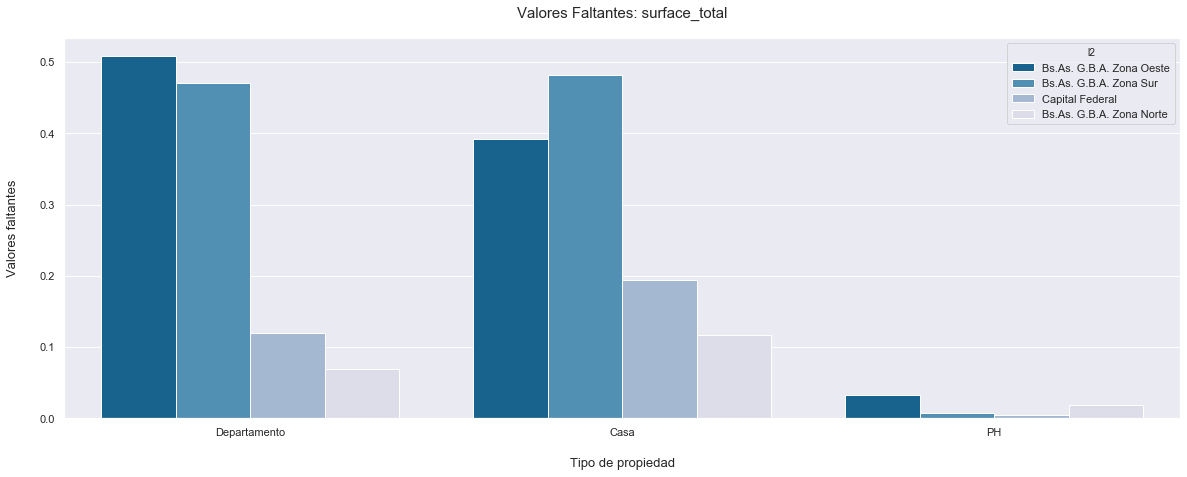

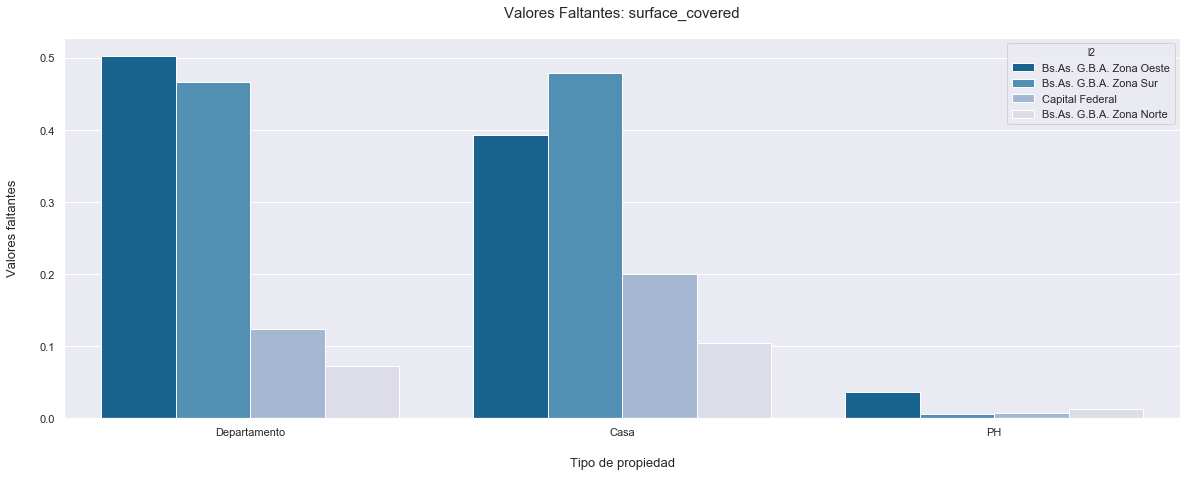

In [25]:
plt.figure(figsize=(20, 7))
barplot_missing_values(data, 'surface_total')
plt.show()

plt.figure(figsize=(20, 7))
barplot_missing_values(data, 'surface_covered')
plt.show()

#### Encoding

* Creando variables dummy para *l2* y *property_type*

In [26]:
bin_propertyType = LabelBinarizer()
bin_l2 = LabelBinarizer()

In [27]:
dummy_propertyType = bin_propertyType.fit_transform(
    data[['property_type']])
dummy_l2 = bin_l2.fit_transform(data[['l2']])

In [28]:
dummy_l2_names = ['l2_'+'_'.join(col.split()[-2::]) for col in bin_l2.classes_]
dummy_propertyType_names = ['prop_'+col for col in bin_propertyType.classes_]

* Dataframe de dummies

In [29]:
df_dummies = pd.DataFrame(
    np.c_[dummy_l2, dummy_propertyType], columns=dummy_l2_names+dummy_propertyType_names)

In [30]:
df_dummies

,l2_Zona_Norte,l2_Zona_Oeste,l2_Zona_Sur,l2_Capital_Federal,prop_Casa,prop_Departamento,prop_PH
0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1
3,0,0,0,1,0,0,1
4,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
143140,0,0,1,0,0,1,0
143141,1,0,0,0,0,1,0
143142,1,0,0,0,0,1,0
143143,1,0,0,0,0,1,0


In [31]:
data_with_dummies = pd.merge(
    data, df_dummies, on=data.index).drop('key_0', axis=1)

In [32]:
data_with_dummies.drop(data_with_dummies.select_dtypes('object').columns, axis=1, inplace=True)

In [33]:
data_with_dummies

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,missing_bathrooms,l2_Zona_Norte,l2_Zona_Oeste,l2_Zona_Sur,l2_Capital_Federal,prop_Casa,prop_Departamento,prop_PH
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,0,0,0,1,0,1,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,1,0,0,1
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,1,0,0,1
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,1,0,0,1
4,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143140,2.0,1.0,1.0,54.0,48.0,165000.0,0,0,0,1,0,0,1,0
143141,4.0,3.0,2.0,164.0,90.0,130000.0,0,1,0,0,0,0,1,0
143142,1.0,1.0,1.0,50.0,35.0,73000.0,0,1,0,0,0,0,1,0
143143,2.0,1.0,1.0,38.0,38.0,68000.0,0,1,0,0,0,0,1,0


No se realizó el procedimiento para la columna l3 (Barrios) ya que ésta posee demasiadas categorias (>50) que al crear el dummy se obtendría un dataset saturado de dimensiones.

#### Imputación de valores faltantes

Se utilizarán dos métodos para imputar las superficies total y cubierta, el primero mediante sklearn pasando un estimador como parámetro, después se imputará a través de un modelo e iterando por las columnas con valores faltantes (a mano). Se compararan ambos metodos y se elegira el mejor.

Copia del dataframe:

In [34]:
data_method1 = data_with_dummies.copy()

__1. Con Sklearn:__

In [35]:
iterative_imputer = IterativeImputer(
    DecisionTreeRegressor(), add_indicator=True, random_state=0)
iterative_imputer.fit(data_method1)

C:\Users\Erick\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=True,
                 estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                                 max_depth=None,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 presort='deprecated',
                                                 random_state=None,
                                                 splitter='best'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max

In [36]:
data_method1 = pd.DataFrame(iterative_imputer.transform(
    data_method1), columns=np.append(data_method1.columns, ['missing_surface_total', 'missing_surface_covered']))

In [37]:
data_method1.isna().sum()

rooms                      0
bedrooms                   0
bathrooms                  0
surface_total              0
surface_covered            0
price                      0
missing_bathrooms          0
l2_Zona_Norte              0
l2_Zona_Oeste              0
l2_Zona_Sur                0
l2_Capital_Federal         0
prop_Casa                  0
prop_Departamento          0
prop_PH                    0
missing_surface_total      0
missing_surface_covered    0
dtype: int64

* Mapa de dispersion de Valores Faltantes vs No Faltante

In [38]:
def scatterplot_surfaces_price(data):
    sns.set()
    plt.figure(figsize=(20, 14))
    fontdict = {'fontsize': 20}

    for i, col in enumerate(['surface_total', 'surface_covered']):
        # Mascara
        ismissing = (data['missing_'+col] == 1)

        # Plot
        plt.subplot(2, 1, i+1)
        sns.scatterplot(data[col],
                        data.price,
                        hue=data['missing_' + col],
                        style=data['missing_'+col],
                        palette=['#DB4437', 'black'],
                        size=data['missing_'+col],
                        sizes=(200, 200), alpha=.5)

        plt.title('Dispersión: Valores Faltantes/No Faltantes',
                  fontdict=fontdict)
        plt.legend(fontsize='x-large')
        plt.xlabel(col, fontdict=fontdict, labelpad=15)
        plt.ylabel('Precio', fontdict=fontdict, labelpad=15)
        plt.tight_layout(pad=3.0)

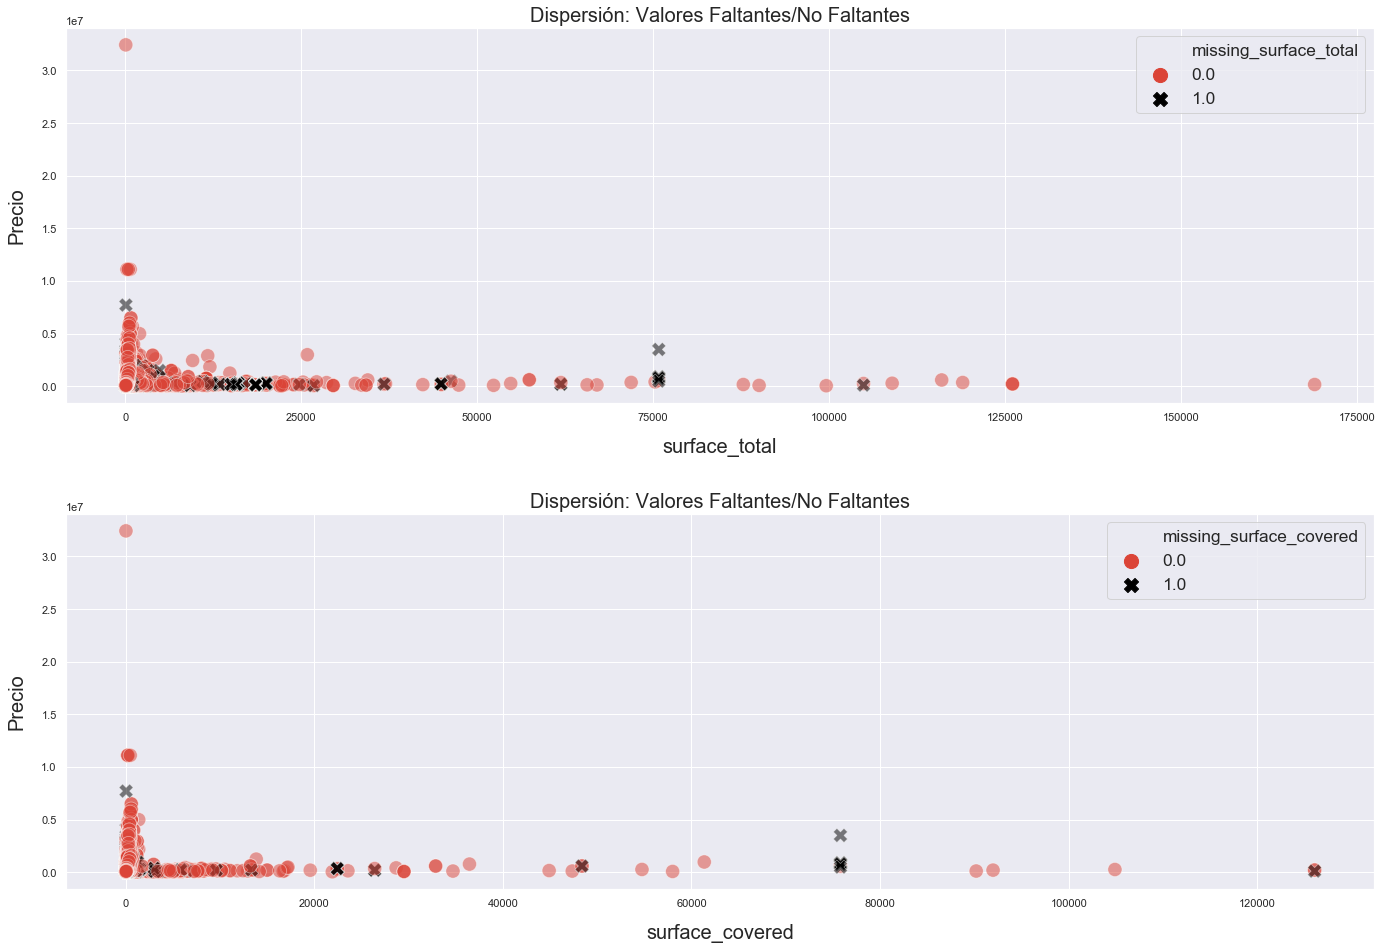

In [39]:
scatterplot_surfaces_price(data_method1)

__2. Procedimiento manual__

Se creará un algoritmo que itere sobre las columnas faltantes eligiendo como datos de entrenamientos los No Faltantes de todas las columnas con excepción de la columna objetivo, esta columna será definida como el target de entrenamiento.

In [40]:
data_method2 = data_with_dummies.copy()

* Indicador de dato faltante:

In [41]:
# Surface covered
missingInd_surf_covered = MissingIndicator().fit_transform(
    data_method2[['surface_covered']])

# surface_total
missingInd_surf_total = MissingIndicator().fit_transform(
    data_method2[['surface_total']])

In [42]:
data_method2['missing_surface_covered'] = missingInd_surf_covered.astype(int)
data_method2['missing_surface_total'] = missingInd_surf_total.astype(int)

In [43]:
while data_method2.isna().sum().any():
    cols_with_nan = data_method2.columns[data_method2.isna().any()]
    cols_no_nan = data_method2.columns.difference(cols_with_nan)
    #Se elige la primera columna con valores faltantes, el orden es imprescindible
    col_nan = cols_with_nan[0]
    df_m2 = data_method2[np.append(cols_no_nan, col_nan)]
    X_train_m2 = df_m2.dropna()[cols_no_nan]
    y_train_m2 = df_m2.dropna()[col_nan]
    #Para los datos de validacion se seleccionan aquellos registros 
    #                           en donde la columna objetivo presenta valores faltantes.
    X_test_m2 = df_m2[df_m2[col_nan].isna()][cols_no_nan]
    #Entrenando el modelo
    model_imputer = DecisionTreeRegressor(
        random_state=0).fit(X_train_m2, y_train_m2)
    y_imputed = model_imputer.predict(X_test_m2)
    data_method2.loc[data_method2[col_nan].isna(), col_nan] = y_imputed

In [44]:
data_method2.isna().sum()

rooms                      0
bedrooms                   0
bathrooms                  0
surface_total              0
surface_covered            0
price                      0
missing_bathrooms          0
l2_Zona_Norte              0
l2_Zona_Oeste              0
l2_Zona_Sur                0
l2_Capital_Federal         0
prop_Casa                  0
prop_Departamento          0
prop_PH                    0
missing_surface_covered    0
missing_surface_total      0
dtype: int64

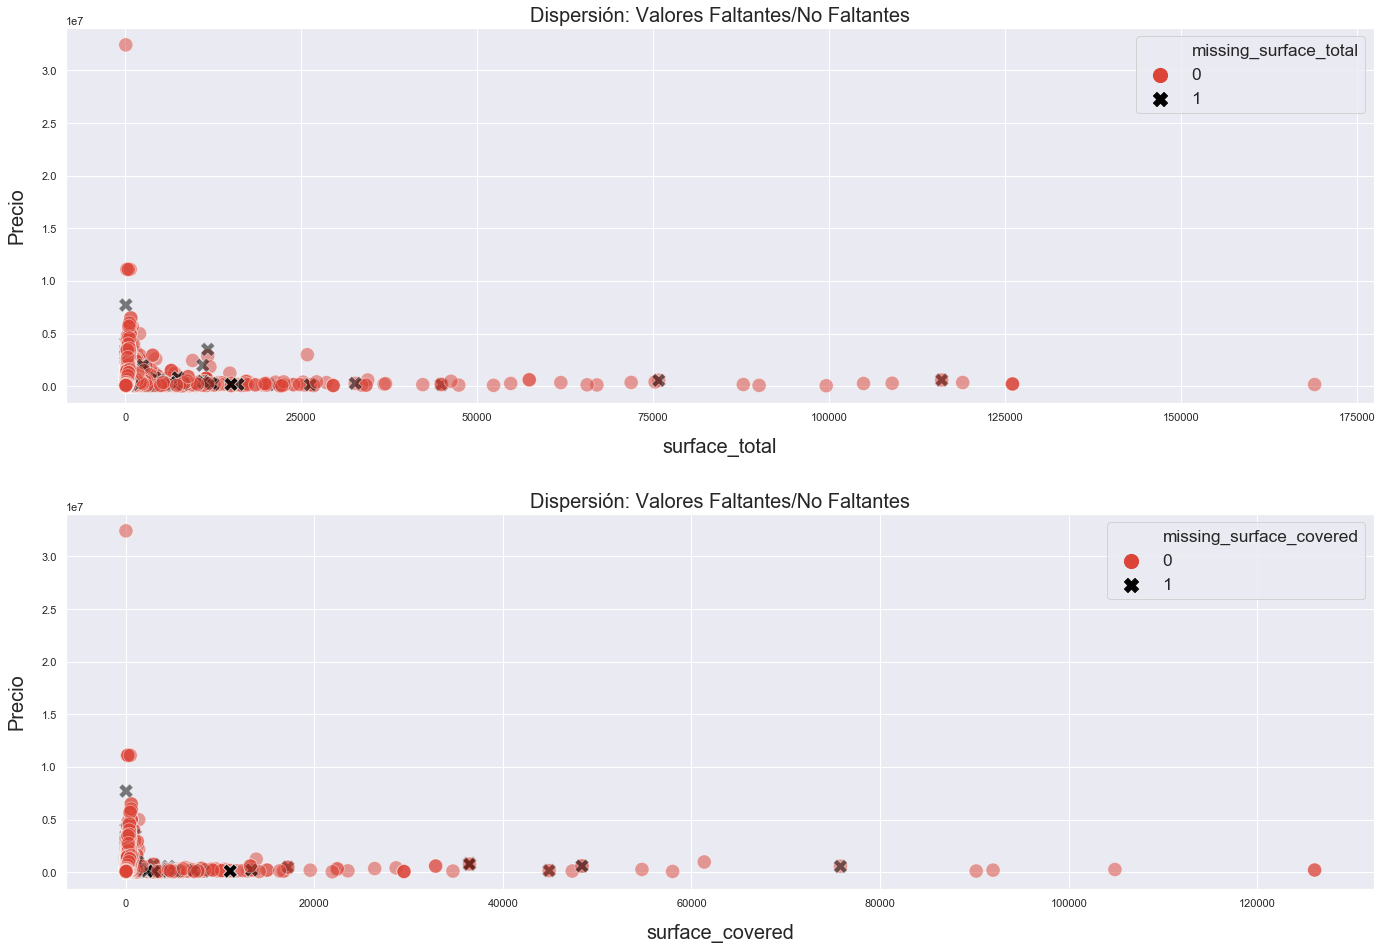

In [45]:
scatterplot_surfaces_price(data_method2)

* Asignando el dataframe sin valores faltantes mediante Sklearn, ya que usa un método optimizado para imputar estos valores; con el algoritmo elaborado manuamente es posible que se esten omitiendo casos sin considerar causando pérdida de información.

In [46]:
data = data_method1

In [47]:
data.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,missing_bathrooms,l2_Zona_Norte,l2_Zona_Oeste,l2_Zona_Sur,l2_Capital_Federal,prop_Casa,prop_Departamento,prop_PH,missing_surface_total,missing_surface_covered
0,7.0,7.0,2.0,140.0,140.0,153000.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.0,1.0,1.0,45.0,45.0,125000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2.0,1.0,1.0,85.0,50.0,295000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2.0,1.0,1.0,50.0,35.0,40000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
print(data.isna().sum())

rooms                      0
bedrooms                   0
bathrooms                  0
surface_total              0
surface_covered            0
price                      0
missing_bathrooms          0
l2_Zona_Norte              0
l2_Zona_Oeste              0
l2_Zona_Sur                0
l2_Capital_Federal         0
prop_Casa                  0
prop_Departamento          0
prop_PH                    0
missing_surface_total      0
missing_surface_covered    0
dtype: int64


####  Deteccion y eliminacion de Outliers

Se eliminaran los valores outliers mediante clusterizacion con DBSCAN y el metodo IQR en las columnas *surface_total* y *price*, luego se compara el resultado obtenido de ambos metodos.

##### DBSCAN

In [49]:
data_dbscan = data.copy()

In [50]:
dbscan = DBSCAN(eps=15, min_samples=20).fit(data_dbscan)

In [51]:
print(str((dbscan.labels_ == -1).sum())+' outliers')

48537 outliers


Transformación inversa de dummy a categórica de los tipos de propiedad, para poder distinguir en las próximas gráficas:

In [52]:
def inverse_transform_prop_type(data):
    return bin_propertyType.inverse_transform(
        np.stack([data.prop_Casa, data.prop_Departamento, data.prop_PH], axis=1))

In [53]:
data_dbscan['property_type'] = inverse_transform_prop_type(data_dbscan)

Asignando etiqueta al dataframe para clasificar los outliers:

In [54]:
data_dbscan['is_outlier'] = dbscan.labels_ == -1
is_outliers_dbscan = data_dbscan['is_outlier']

Distribución de la superficie cubierta para los tipos de propiedad:

In [55]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, size=20,
            ha="left", va="center", transform=ax.transAxes)

In [56]:
def distplot_property_type(data, column, hue):
    sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.FacetGrid(data, aspect=8, row=hue, hue=hue, height=2.5,
                      palette=['#4285F4', '#DB4437', '#0F9D58'])
    g = g.map(sns.kdeplot, column, alpha=1, shade=True)

    g = g.map(plt.axhline, lw=10)
    g.map(label, column)
    g.set_titles('')
    g.fig.subplots_adjust(hspace=-.15)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    sns.set()

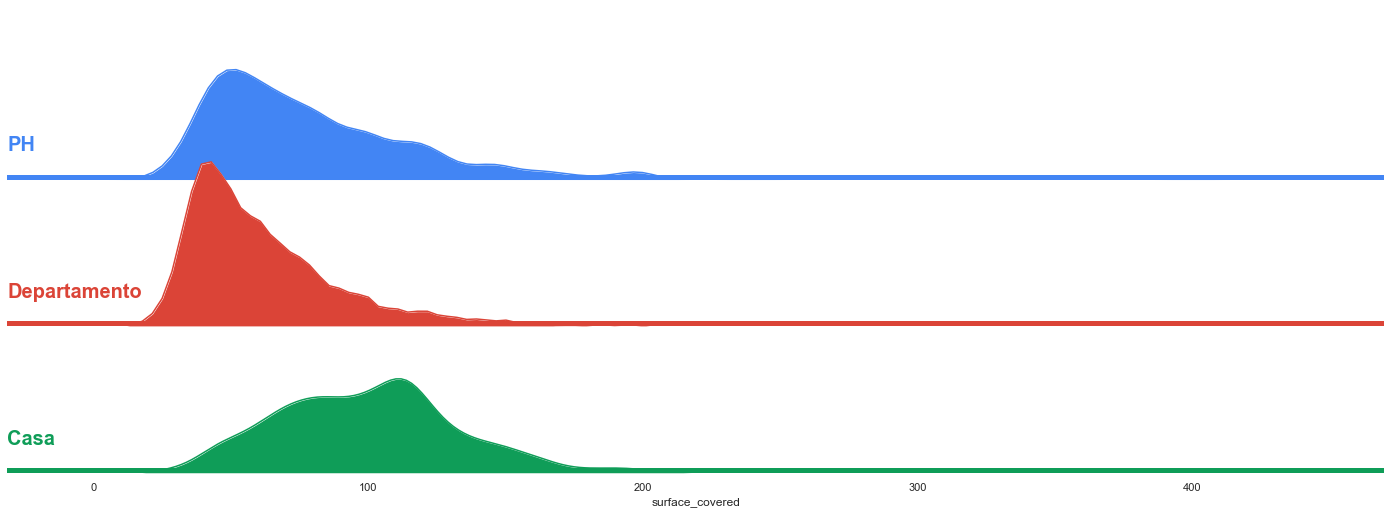

In [57]:
distplot_property_type(
    data_dbscan[~is_outliers_dbscan], 'surface_covered', 'property_type')

Examinando dispersion de datos:

In [58]:
def scatter_plot(data, title, col_x, col_y='price', hue='property_type'):
    plt.figure(figsize=(7, 5))
    plt.title(title, fontdict=dict(fontsize=15))
    s = sns.scatterplot(data[col_x],
                        data[col_y],
                        hue=data[hue],
                        palette=['#714cfe', '#09AF00', '#fa8100'],
                        alpha=.6,
                        s=70)

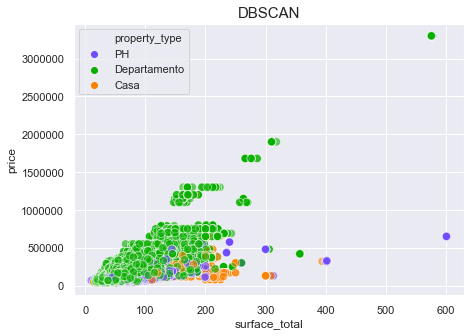

In [59]:
scatter_plot(data_dbscan[~is_outliers_dbscan], 'DBSCAN', 'surface_total')

In [60]:
#data_dbscan = data_dbscan[~is_outliers_dbscan]
data_dbscan.drop(['is_outlier', 'property_type'], axis=1, inplace=True)

##### IsolationForest

In [61]:
data_isolation = data.copy()

Creando la instancia del objeto y entrenándolo:

In [62]:
isoForest = IsolationForest(n_estimators=200,
                            contamination=.25, random_state=42).fit_predict(data_isolation)

In [63]:
print(f'{(isoForest==-1).sum()} outliers')

35786 outliers


In [64]:
data_isolation['property_type'] = inverse_transform_prop_type(data_isolation)

Asignando etiqueta al dataframe para clasificar los outliers:

In [65]:
data_isolation['is_outlier'] = isoForest == -1
is_outlier_isoforest = data_isolation['is_outlier']

Distribución de la superficie cubierta para los tipos de propiedad:

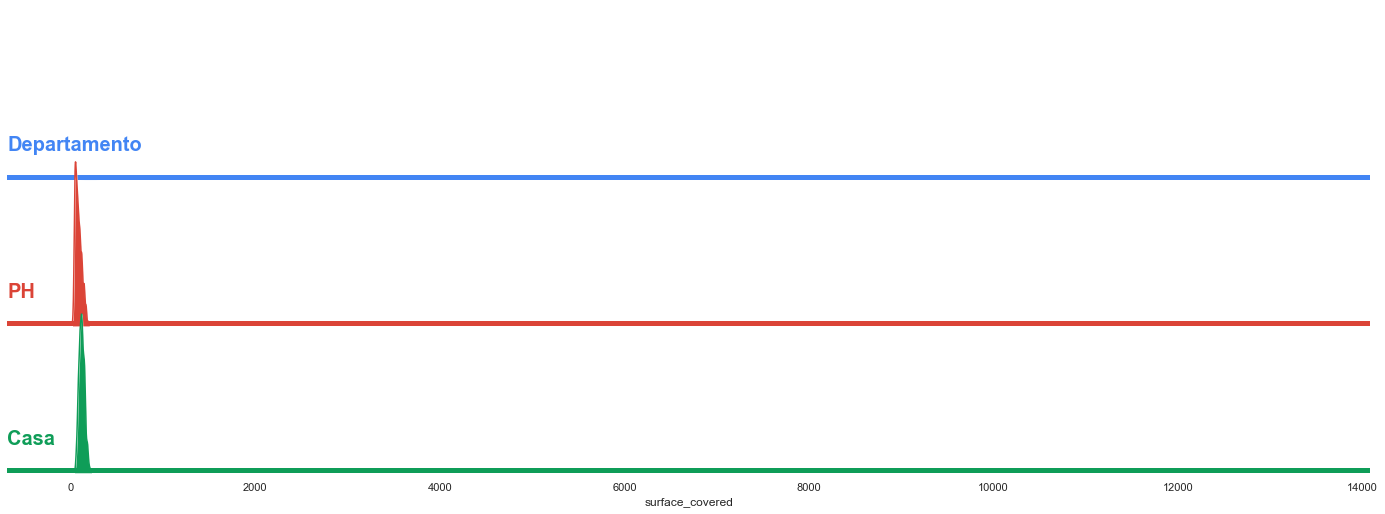

In [66]:
distplot_property_type(
    data_isolation[~is_outlier_isoforest], 'surface_covered', 'property_type')

Dispersion de datos:

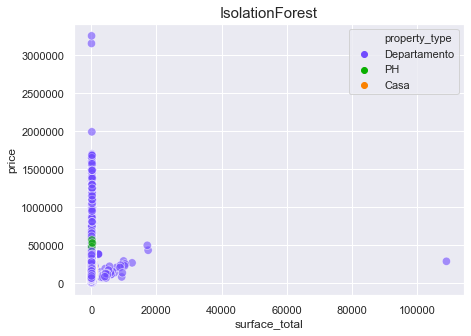

In [67]:
scatter_plot(data_isolation[~is_outlier_isoforest],
             title='IsolationForest', col_x='surface_total')

In [68]:
data_isolation = data_isolation[~is_outlier_isoforest]
data_isolation.drop(['property_type', 'is_outlier'], inplace=True, axis=1)

##### LocalOutlierFactor

In [69]:
data_LOF = data.copy()

Escalado de datos:

In [70]:
standarScaler_LOF = RobustScaler()
data_LOF_scaled = standarScaler_LOF.fit_transform(
    data_LOF.drop('price', axis=1))
data_LOF_scaled = pd.DataFrame(
    data_LOF_scaled, columns=data_LOF.drop('price', axis=1).columns)
data_LOF_scaled = pd.concat([data_LOF_scaled, data_LOF['price']], axis=1)

Creando la instancia del objeto LocalOutlierFactor:

In [71]:
localOutlierFactor = LocalOutlierFactor(n_jobs=-1, n_neighbors=20, contamination=.25).fit_predict(data_LOF_scaled)

In [72]:
data_LOF_scaled['is_outlier'] = localOutlierFactor == -1
is_outlier_LOF = data_LOF_scaled['is_outlier']
data_LOF_scaled.is_outlier.value_counts()

False    107359
True      35786
Name: is_outlier, dtype: int64

In [73]:
data_LOF_scaled['property_type'] = inverse_transform_prop_type(
    data_LOF)

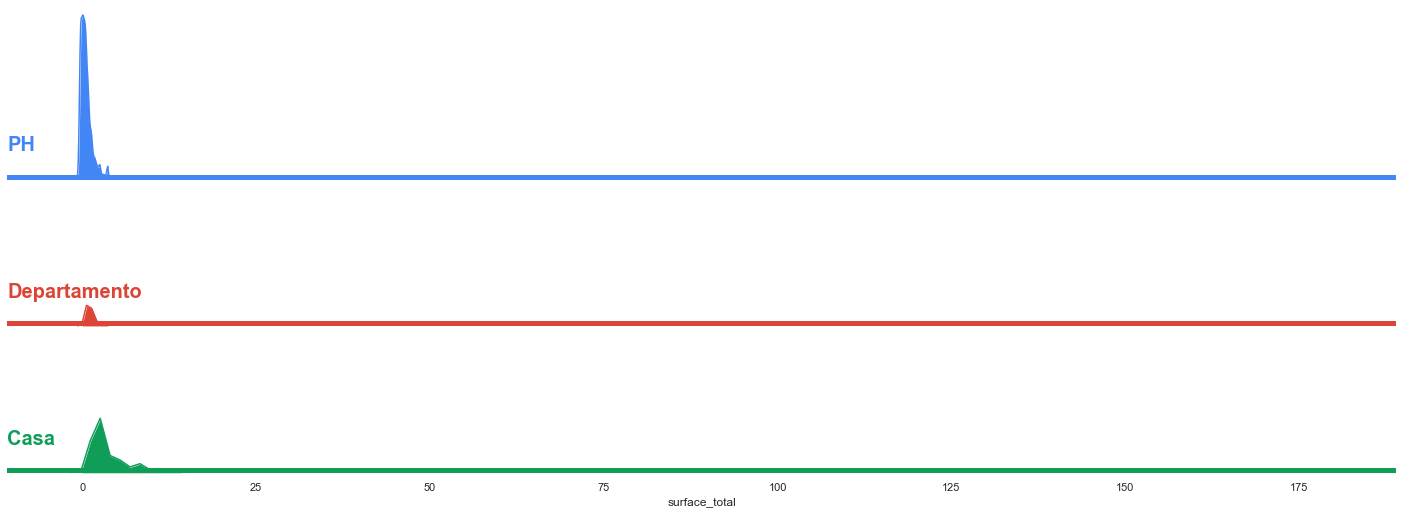

In [74]:
distplot_property_type(
    data_LOF_scaled[~is_outlier_LOF], 'surface_total', 'property_type')

Mapa de dispersion:

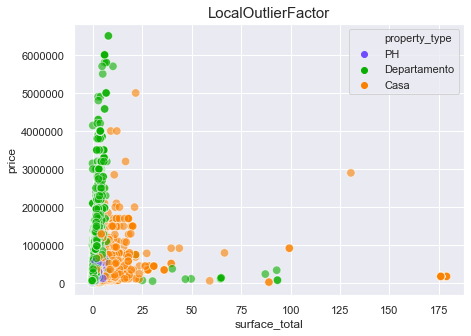

In [75]:
scatter_plot(data_LOF_scaled[~is_outlier_LOF], title='LocalOutlierFactor', col_x='surface_total')

In [76]:
data_LOF_scaled[~is_outlier_LOF].property_type.value_counts()

Departamento    78909
Casa            17198
PH              11252
Name: property_type, dtype: int64

In [77]:
data_LOF_scaled=data_LOF_scaled[~is_outlier_LOF]

In [78]:
drop_colummns = ['is_outlier', 'property_type']
data_LOF_scaled.drop(drop_colummns, axis=1, inplace=True)

##### IQR

In [79]:
data_iqr = data.copy()

In [80]:
# Funcion para remover outliers mediante metodo IQR
def remove_outliers_iqr(column, data):
    q1 = data[column].quantile(.25)
    q3 = data[column].quantile(.75)
    iqr = q3-q1
    min_iqr = q1-1.5*iqr
    max_iqr = q3+1.5*iqr
    return data.query(f'@min_iqr <= {column} <= @max_iqr')

In [81]:
data_iqr = remove_outliers_iqr('price', data_iqr)
data_iqr = remove_outliers_iqr('surface_total', data_iqr)
data_iqr = remove_outliers_iqr('surface_covered', data_iqr)

In [82]:
data_iqr['property_type'] = inverse_transform_prop_type(data_iqr)

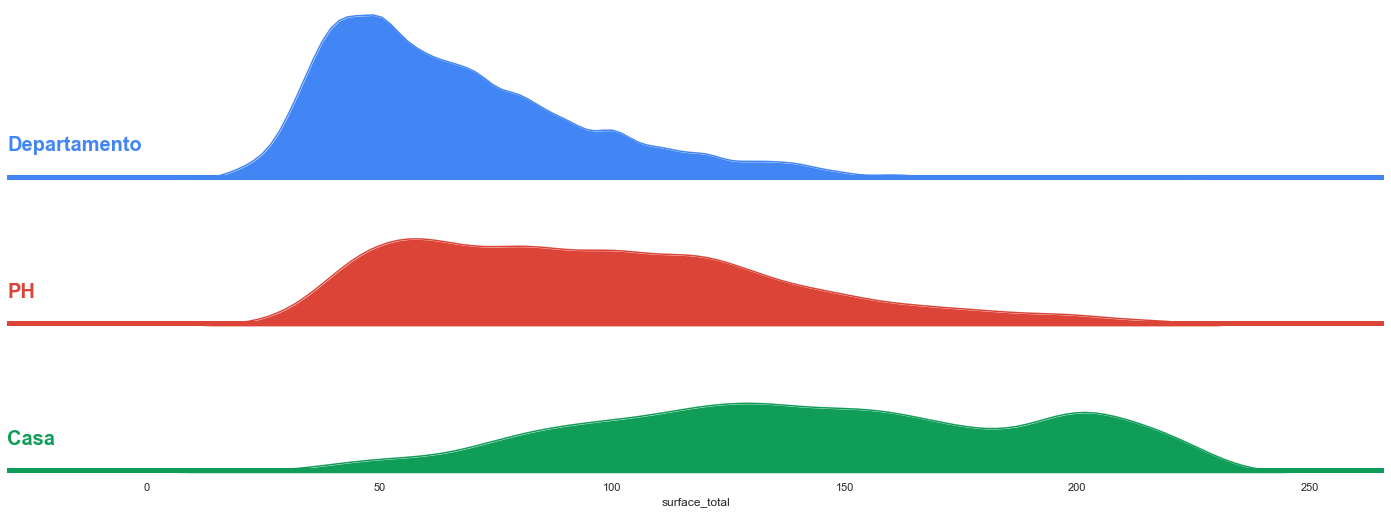

In [83]:
distplot_property_type(data_iqr, 'surface_total', 'property_type')

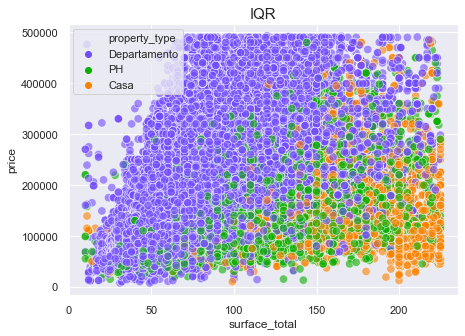

In [84]:
scatter_plot(data_iqr, title='IQR', col_x='surface_total')

In [85]:
data_iqr.drop('property_type', axis=1, inplace=True)

**Conclusiones:**

Al observar la dispersion de la superficie total con respecto al precio con el metodo LocalOutputFactor se nota una clara separacion entre dos tipos de propiedad, lo cual puede beneficiar el modelo. El metodo DBSCAN parece superar a IsolationForest porque la distribucion obtenida es mas parecida a la normal, pero la dispersion de los datos no es muy clara.

El Metodo IQR parece efectivo, sin embargo se hizo el ajuste para las 3 variables. Al eliminar instancias de una variable se perderia informacion potencialmente importante.

Al realizar iteraciones con los algoritmos de Sklearn obtuve menores error con IsolationForest aplicando una contaminacion del 25%.

Se intentó con StandarScaler, MinMaxScaler, y finalmente con RobustScaler el rendimiento mejoró.

In [86]:
data_final = data_isolation  # IsolationForest
robustScaler = RobustScaler()
scaled_data_final = robustScaler.fit_transform(
    data_final.drop('price', axis=1))

In [87]:
stack_columns = np.c_[scaled_data_final, data_final.price]
scaled_data_final = pd.DataFrame(stack_columns, columns=np.append(
    data_final.drop('price', axis=1).columns, ['price']))

#### PCA

Al desconocer el numero de componentes ideal, se decidio crear un ciclo hasta el numero de componentes maximo para obtener la suma de las varianzas y el valor RMSE de un modelo basico de arbol de decisión:

In [88]:
variances = []
individual_variances = []
error_test, error_train = [], []
n_components = np.arange(1, len(scaled_data_final.columns))

for i in n_components:
    pca_loop = PCA(n_components=i)
    data_pca_loop = pca_loop.fit_transform(scaled_data_final.drop(
        ['price'], axis=1))
    variance_ratio = pca_loop.explained_variance_ratio_
    individual_variances.append(variance_ratio)
    variances.append(variance_ratio.sum())

    # Entrenamiento Modelos
    X = data_pca_loop
    y = scaled_data_final.price
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.3, random_state=0)
    tree = DecisionTreeRegressor(random_state=20).fit(X_train, y_train)
    y_pred_test = tree.predict(X_test)
    y_pred_train = tree.predict(X_train)
    error_test.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    error_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))

* Curva de errores en Entrenamiento y Validacion.

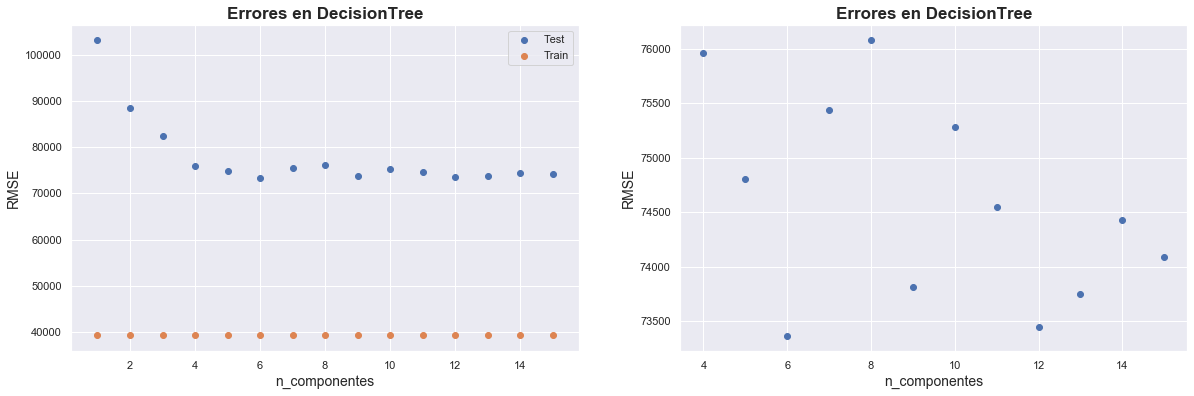

In [89]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
font_title=dict(fontsize=17, fontweight='bold')
font_axis=dict(fontsize=14)
plt.xlabel('n_componentes', fontdict=font_axis)
plt.ylabel('RMSE', fontdict=font_axis)
plt.title('Errores en DecisionTree', fontdict=font_title)
plt.scatter(n_components, error_test, label='Test')
plt.scatter(n_components, error_train, label='Train')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('n_componentes', fontdict=font_axis)
plt.ylabel('RMSE', fontdict=font_axis)
plt.title('Errores en DecisionTree', fontdict=font_title)
plt.scatter(n_components[3:], error_test[3:], label='Test')

* Analisis Varianzas

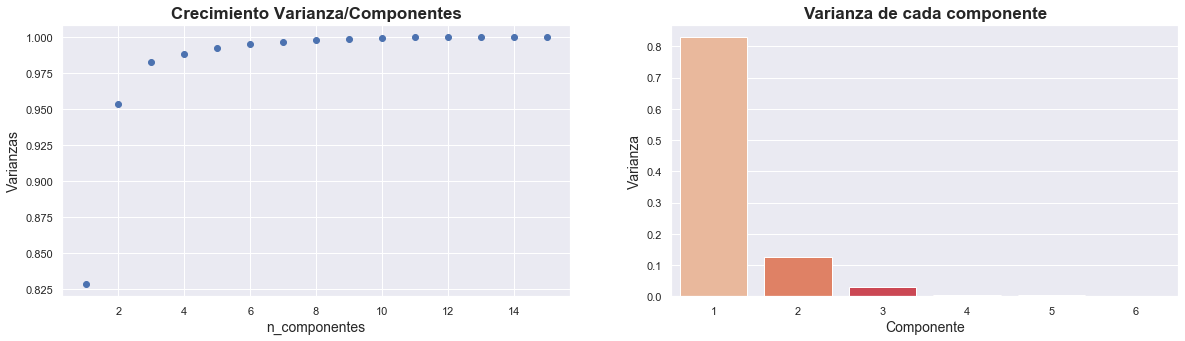

In [90]:
font_title = dict(fontsize=17, fontweight='bold')
font_axis = dict(fontsize=14)
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.xlabel('n_componentes', fontdict=font_axis)
plt.ylabel('Varianzas', fontdict=font_axis)
plt.title('Crecimiento Varianza/Componentes', fontdict=font_title)
plt.plot(n_components, variances,'o')

plt.subplot(1, 2, 2)
k = 6
plt.title('Varianza de cada componente', fontdict=font_title)
plt.xlabel('Componente', fontdict=font_axis)
plt.ylabel('Varianza', fontdict=font_axis)
sns.barplot(np.arange(1, k+1), individual_variances[k-1], palette='rocket_r')

En el primer grafico, los errores en Arbol de Decision estan entre 70.000 y 80.000 dolares a partir de 4 componentes, en el segundo grafico de Crecimiento de Varianza/Componentes vemos que a partir de 2 componentes se obtienen varianzas superiores al  95%.  
  
Seleccionar 6 componentes sería una opción viable porque corresponde a una varianza cercana al 100% y segun la curva de errores corresponde al valor minimo. Tambien con 12 componentes equivale a varianza casi del 100% y con el minimo error (con una diferencia poco notable) pero por esta razon se esta aplicando la reduccion con PCA, seleccionar el menor numero de componentes posibles que expliquen los datos.

Creando PCA con 6 componentes:

In [91]:
pca = PCA(n_components=6)
data_pca = pca.fit_transform(scaled_data_final.drop('price', axis=1))

#### Modelo Benchmark

In [92]:
X = data_pca
y = scaled_data_final.price
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42)

In [93]:
tree_model = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
y_pred_test = tree_model.predict(X_test)
y_pred_train = tree_model.predict(X_train)

print('Root Mean Squared Error en Test', np.sqrt(
    mean_squared_error(y_test, y_pred_test)))
print('Root Mean Squared Error en Train', np.sqrt(
    mean_squared_error(y_train, y_pred_train)))

Root Mean Squared Error en Test 72435.95329691879
Root Mean Squared Error en Train 39720.81355912008


**Con el dataset obtenido con IsolationForest se reduce el error en gran medida**

### Parte B - Modelos Avanzados

#### Benchmarks
Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

Función para distribución de errores:

In [94]:
def dist_errors(model, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f'Modelo: {model_name}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.distplot(y_train - y_train_pred, bins=20, label='train')
    sns.distplot(y_test - y_test_pred, bins=20, label='test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.scatter(y_test, y_test_pred, s=2)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

##### Modelos de Regresion Lineal:  LinearRegression, Lasso y Ridge

In [95]:
#Generando atributos polinomiales
poly_features = PolynomialFeatures(include_bias=False)
X_train_new = poly_features.fit_transform(X_train)
X_test_new = poly_features.transform(X_test)

Creacion de Modelos:

In [96]:
linear_model = LinearRegression()
lasso_model = Lasso()
ridge_model = Ridge()

Modelo: Regresion Lineal
Raíz del error cuadrático medio en Train: 117274.47520046195
Raíz del error cuadrático medio en Test: 129212.77766844784


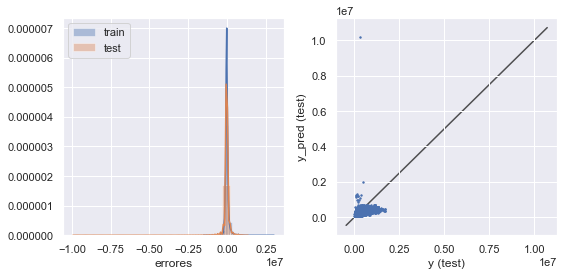

Modelo: Lasso
Raíz del error cuadrático medio en Train: 117274.47526409224
Raíz del error cuadrático medio en Test: 129212.21556885017


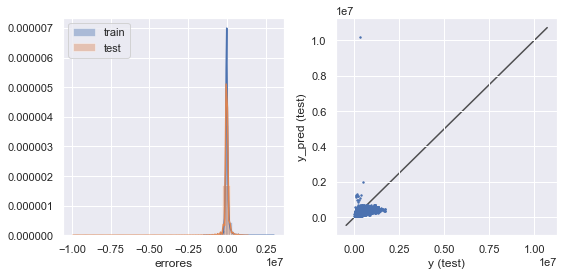

Modelo: Ridge
Raíz del error cuadrático medio en Train: 117274.4752327996
Raíz del error cuadrático medio en Test: 129213.05827017374


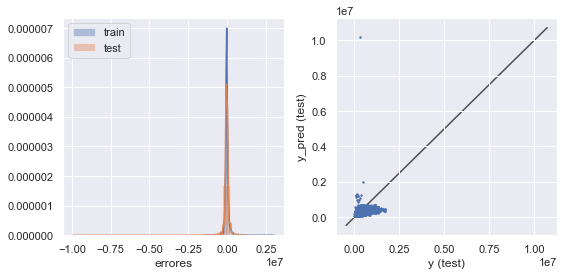

In [97]:
for title, model in zip(['Regresion Lineal', 'Lasso', 'Ridge'], [linear_model, lasso_model, ridge_model]):
    model.fit(X_train, y_train)
    dist_errors(model, title)

* _Primera Iteracion:_ Se aplico Regularizacion con Ridge y Lasso con atributos polinomiales obteniendo valores RMSE muy altos.

* _Segunda Iteracion:_ Mismos modelos sin atributos polinomicos retornando errores mas bajos. Con los modelos LinearRegression y Ridge se obtuvo el error mas bajo con $129.212 dolares

##### Modelos de Ensamble: RandomForest , Ensamble de KNN y XGBoost

__Paso 1.__ Creacion de modelos:

In [98]:
# CV RandomForest
randomForest = RandomForestRegressor(random_state=0)

# CV Ensamble KNN
bagging_knn = BaggingRegressor(KNeighborsRegressor(
    leaf_size=70, n_neighbors=20, weights='distance'), random_state=0, n_estimators=20)

# CV XGBRegressor
xgbRegressor = XGBRegressor(random_state=0)

__Paso 2.__ Validacion Cruzada:

In [99]:
n_cv = 10

# CV RandomForest
randomForest_scores = cross_val_score(randomForest, X, y, n_jobs=-1, cv=n_cv)

# CV Ensamble KNN
bagging_knn_scores = cross_val_score(bagging_knn, X, y, n_jobs=-1, cv=n_cv)

# CV XGBRegressor
xgbRegressor_scores = cross_val_score(xgbRegressor, X, y, n_jobs=-1, cv=n_cv)

In [100]:
models=['RandomForest', 'Ensamble KNN', 'XGBRegressor']
for name, model_score in zip(models,[randomForest_scores, bagging_knn_scores, xgbRegressor_scores]):
    print(f"Accuracy para {name}: %0.2f (+/- %0.2f)" % (model_score.mean(), model_score.std() * 2))

Accuracy para RandomForest: 0.83 (+/- 0.05)
Accuracy para Ensamble KNN: 0.83 (+/- 0.05)
Accuracy para XGBRegressor: 0.80 (+/- 0.03)


Se obtuvieron accuracies superiores al 80%, por lo tanto el desempeño de los modelos no dependerá de la partición de los datos.

__Paso 3.__ Entrenamiento de modelos:

In [101]:
randomForest.fit(X_train, y_train)
bagging_knn.fit(X_train, y_train)
xgbRegressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

__Paso 4.__ Distribución de Errores:

Modelo: RandomForest
Raíz del error cuadrático medio en Train: 43396.37607783401
Raíz del error cuadrático medio en Test: 64288.83416866409


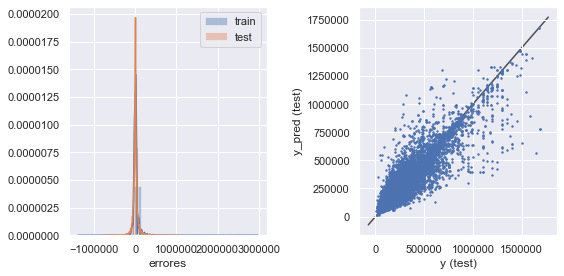

Modelo: Ensamble KNN
Raíz del error cuadrático medio en Train: 43594.29216040112
Raíz del error cuadrático medio en Test: 64345.94717877824


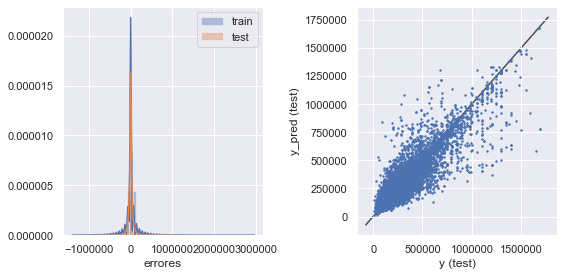

Modelo: XGBRegressor
Raíz del error cuadrático medio en Train: 62255.87371544371
Raíz del error cuadrático medio en Test: 70175.23815676286


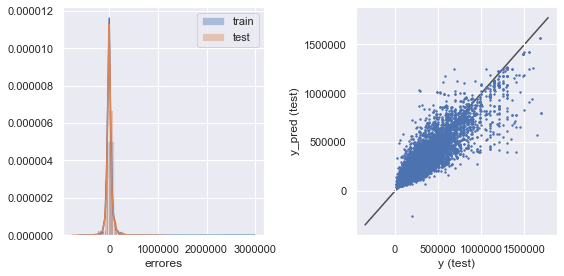

In [102]:
for model_name, model in zip(models, [randomForest, bagging_knn, xgbRegressor]):
    dist_errors(model, model_name)

De los modelos de ensamble anteriores se obtuvo menor error en Test con RandomForest

#### Optimizacion

Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

##### RandomForest

In [133]:
random_grid = {
    'max_depth': np.arange(130, 135),
    'n_estimators': np.arange(170, 175)
}

gridsearch_Forest = GridSearchCV(
    RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=0),
    param_grid=random_grid, n_jobs=-1)

In [134]:
gridsearch_Forest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [135]:
gridsearch_Forest.best_params_

{'max_depth': 130, 'n_estimators': 173}

Modelo: GridSearch RandomForest
Raíz del error cuadrático medio en Train: 43218.10351397305
Raíz del error cuadrático medio en Test: 63935.17370560441


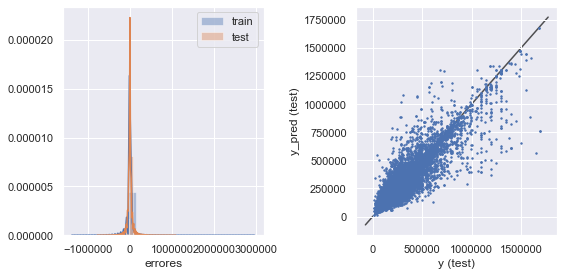

In [136]:
dist_errors(gridsearch_Forest, 'GridSearch RandomForest')

##### XGBoostRegressor

In [247]:
parameters = {'nthread': [4],
              'max_depth': np.arange(13, 16),
              'n_estimators': np.arange(215, 219)
              }

In [248]:
gridsearch_xgboost = GridSearchCV(XGBRegressor(booster='gbtree',
                                             learning_rate=.02,
                                             importance_type='total_cover',
                                             colsample_bytree=0.62,
                                             random_state=0,
                                             n_jobs=-1),
                                param_grid=parameters, n_jobs=-1)

In [249]:
gridsearch_xgboost.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.62, gamma=None,
                                    gpu_id=None, importance_type='total_cover',
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints...
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_para

In [250]:
gridsearch_xgboost.best_params_

{'max_depth': 15, 'n_estimators': 218, 'nthread': 4}

Modelo: GridSearch XGBRegressor
Raíz del error cuadrático medio en Train: 44179.852089187356
Raíz del error cuadrático medio en Test: 63728.0161091556


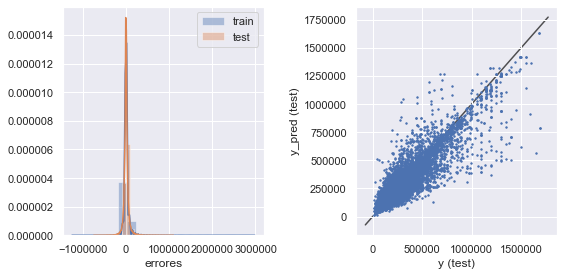

In [251]:
dist_errors(gridsearch_xgboost, 'GridSearch XGBRegressor')

#### Comparacion

Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

In [213]:
#COMPARAR

### Parte C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?



### Desafío Opcional

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?



In [346]:
scaled_data_final_no_props = scaled_data_final.copy()

In [347]:
result = [scaled_data_final_no_props.drop(col, axis=1, inplace=True)
          for col in scaled_data_final_no_props.columns if col.startswith('prop_')]

In [357]:
kmean=DBSCAN(eps=0.5, min_samples=25).fit(scaled_data_final_no_props)

In [358]:
np.unique(kmean.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

## Checklist de evaluación

Sugerencias para desarrollar el proyecto:

Este proyecto no cuenta con mínimos entregables indicados en la consigna, pero ten en cuenta lo siguiente:
en la Parte A debes implementar al menos tres de las transformaciones de datos propuestas.
en la Parte B, al menos un modelo debe ser optimizado por Grid Search o Random Search; el otro puede ser optimizado por búsqueda manual (es decir, puedes dejar los mejores parámetros que encontraste probando ).
en la Parte C, debes responder al menos una pregunta. Obviamente, ¡cuanto más hagas, más aprenderás y mejor será tu proyecto!

La resolución del proyecto te puede enfrentar a pequeños desafíos que no trabajamos durante los encuentros. Es importante que desarrolles la capacidad de resolverlos. Para ello, consulta las bitácoras, las referencias, los notebooks vistos en clase, la documentación de la librería y, sobre todo, googlea .

Antes de subir tu proyecto a la plataforma Acámica para que sea evaluado, verifica que el Notebook se ejecute sin errores. Además, asegúrate de cumplir con las siguientes condiciones (son las que los/as evaluadores/as tendrán en consideración al momento de corregir tu trabajo):

### Parte A - Transformación de Datos

Debes justificar por qué creés que las transformaciones elegidas aplican en este dataset.

Debes re entrenar un modelo del Proyecto 01 y comparar su desempeño con el modelo obtenido en el Proyecto 01.

### Parte B - Modelos Avanzados

En la optimización de hiperparámetros, debes justificar los parámetros que elegiste para optimizar y el rango de cada uno.

### Parte C - Interpretación de modelos

Debes estudiar qué variables utiliza el modelo para predecir y responder la pregunta: ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

Es muy importante que analices los errores del modelo. ¿Dónde es mayor el error? ¿dónde acierta?

Debes ser crítico/a con la metodología utilizada. ¿Qué mejorarías?